In [2]:
import os
import sys
from scipy.integrate import solve_ivp
import numpy as np
from numpy.linalg import norm
from numpy import sqrt
from sklearn.metrics import accuracy_score
from math import pi
import pickle
import matplotlib.pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import play_trajs, rotate, sp2a, v2sp, dist, psi, beta, d_theta, d_psi, sp2v, dist, min_dist
from packages.ode_simulator import ODESimulator
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1_data.pickle'))
with open(file, 'rb') as f:
    data = pickle.load(f)
file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1b_data.pickle'))
with open(file, 'rb') as f:
    data2 = pickle.load(f)

In [56]:
set(data.info['subj_id'])
# set(data.info['obst_speed'])
data.info['stimuli_onset'][7]


236

In [3]:
'''Animate data'''
############
subject = 0
trial = 31

############
%matplotlib qt
i = subject * 160 + trial - 1
# p_obst = np.array(data.info['p_obst'][i])
t0 = data.info['stimuli_onset'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
play_trajs(trajs, ws, data.Hz, title=title)


In [4]:
'''Plot data by condition'''
#####################
subject = 2
con_ang = [90]
con_spd = [1.2]
# con_ang = set(data.info['obst_angle'])
# con_spd = set(data.info['obst_speed'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data.trajs)):
    obst_speed = data.info['obst_speed'][i]
    obst_angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (obst_speed in con_spd and abs(obst_angle) in con_ang):
        continue
    subj = np.array(data.get_traj(i))
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if obst_angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    plt.plot(obst[:, 0], obst[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('subj ' + str(subject) + ' angle: ' + str(con_ang[0]) + ' speed: ' + str(con_spd[0]))

Text(0.5, 1.0, 'subj 2 angle: 90 speed: 1.2')

In [3]:
'''Plot data by subject'''
#####################
subject = 3
#####################
%matplotlib qt
fig = plt.figure()
fig.suptitle('Subject ' + str(subject))
axes = {}
obst_angle = [90, 112.5, 135, 157.5, 180]
obst_speed = [0.9, 1.0, 1.1, 1.2, 1.3]
i_plot = 1
for angle in obst_angle:
    for speed in obst_speed:
        axes[(angle, speed)] = fig.add_subplot(5, 5, i_plot)
        axes[(angle, speed)].set_xlim(-3, 3)
        axes[(angle, speed)].set_ylim(-7, 5)
        axes[(angle, speed)].set_title(str(angle) + '° ' + str(speed) + 'm/s')
        axes[(angle, speed)].set_aspect('equal')
        i_plot += 1
for i in range(len(data.trajs)):
    speed = data.info['obst_speed'][i]
    angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject or speed == 0:
        continue
    subj = np.array(data.get_traj(i))
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    axes[(abs(angle), speed)].plot(subj[:, 0], subj[:, 1])
    axes[(abs(angle), speed)].plot(obst[:, 0], obst[:, 1])

Loading finished
passing order matching rate  0.7138888888888889
0.6703662597114317  matching rate for trials with initial dpsi smaller than  0.02


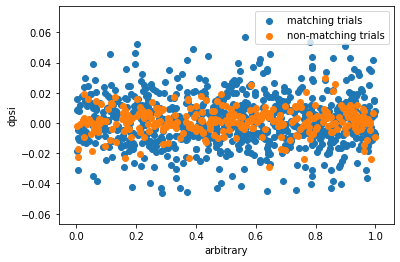

In [9]:
'''Check initial dpsi and subject passing choice, plot dpsi of matching and non-matching trials'''
sim = ODESimulator(data=data, ref=[0,1])
side_pred = []
side_true = []
subjects = range(9)
dpsi_match = []
dpsi_not = []
for i in range(len(sim.data.trajs)):
    if (sim.data.info['subj_id'][i] in subjects and
        sim.data.info['obst_speed'][i] != 0 and
        abs(sim.data.info['obst_angle'][i]) != 180):
        xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, phi, s, dphi, ds = sim.compute_var0(i, sim.data.info['stimuli_onset'][i])
        # When beta and dpsi has the same sign it means pass in front, otherwise it means pass from behind
        dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
        b = beta([x, y], [xo, yo], [vx, vy])
        side_pred.append(b * dpsi > 0)
        subj = sim.data.get_traj(i)
        obst = sim.data.info['p_obst'][i]
        _, mind = min_dist(subj, obst)
        side_true.append(mind > 0)
        if side_pred[-1] == side_true[-1]:
            dpsi_match.append(dpsi)
        else:
            dpsi_not.append(dpsi)
print('passing order matching rate ', accuracy_score(side_true, side_pred))
plt.scatter(np.random.uniform(size=len(dpsi_match)), dpsi_match, label='matching trials')
plt.scatter(np.random.uniform(size=len(dpsi_not)), dpsi_not, label='non-matching trials')
plt.ylabel('dpsi')
plt.xlabel('arbitrary')
plt.legend()
thres = 0.02
a, b = sum([abs(x) < thres for x in dpsi_match]), sum([abs(x) < thres for x in dpsi_not])
print(a/(a+b), ' matching rate for trials with initial dpsi smaller than ', thres)

In [2]:
''' Check optimal parameters from training results '''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'cohen_avoid1_dynamic_match_order_dual_annealing'))
filenames = [os.path.join(path, name) for name in os.listdir(path)]
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i == 2:
                subj_id = int(line[-4:-2])
            err = str(line).split("\\t")[-1][:10]
            if err[0] == '0':
                err = float(err)
                if err < e_min:
                    e_min = err
                    best = str(line).replace("\\", "")
    bests[subj_id] = best

ValueError: could not convert string to float: '0.975\\r\\n"'

In [3]:
for i, best in bests.items():
    print('\n')
    print(i, best)



0 b"3097t[{'name': 'fajen_approach', 'b1': 1.322399694018276, 'k1': 14.876666639462048, 'c1': 5.4374557807911295, 'c2': 0.10260590846412238, 'k2': 0.7564633997176441, 'ps': 1.282479471344188}]t0.07514032635121004rn"


1 b"3685t[{'name': 'fajen_approach', 'b1': 0.8179416797170797, 'k1': 16.40077656118177, 'c1': 6.417008356831993, 'c2': 0.07993938648972572, 'k2': 0.8075364662966444, 'ps': 1.329331601172892}]t0.08859594997718775rn"


2 b"2374t[{'name': 'fajen_approach', 'b1': 0.8909408398978989, 'k1': 4.641459981824929, 'c1': 5.516867857632004, 'c2': 0.31100646722160424, 'k2': 0.9262495070122934, 'ps': 1.2233195327965638}]t0.0905988159781522rn"


3 b"3133t[{'name': 'fajen_approach', 'b1': 1.2318155085696687, 'k1': 0.44596523668254273, 'c1': 8.660447058122513, 'c2': 1.5467823698282144, 'k2': 0.2064201810751935, 'ps': 0.9872111178298977}]t0.14959330685010436rn"


4 b"2728t[{'name': 'fajen_approach', 'b1': 0.9187400116180737, 'k1': 12.354994295866103, 'c1': 5.138764981999261, 'c2': 0.11504

In [ ]:
'''Approach data'''
'''Plot data by condition'''
#####################
subject = 0
s0 = [1.4]
d0 = [8]
angle = [15]
s0 = set(data2.info['goal_s0'])
d0 = set(data2.info['goal_d0'])
angle = set(data2.info['goal_angle'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data2.trajs)):
    goal_s0 = data2.info['goal_s0'][i]
    goal_d0 = data2.info['goal_d0'][i]
    goal_angle = data2.info['goal_angle'][i]
    subj_id = data2.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (goal_s0 in s0 and goal_d0 in d0 and abs(goal_angle) in angle):
        continue
    subj = np.array(data2.info['p_subj'][i])
    goal = np.array(data2.info['p_goal'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
#     if goal_angle < 0:
#         subj[:, 0] *= -1
#         goal[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    print(subj)
    plt.plot(goal[:, 0], goal[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title(f'subj {str(subject)} angle: {str(angle)} s0: {str(s0)} d0: {str(d0)}')